In [1]:
import os, sys, pathlib

REPO_URL = "https://github.com/UmerSR/Connect-Four-RL.git"
WORKSPACE = "/content/Connect-Four-RL"

if not os.path.exists(WORKSPACE):
    !git clone $REPO_URL $WORKSPACE
else:
    %cd $WORKSPACE
    !git pull --ff-only

%cd $WORKSPACE/rl_connect4
sys.path.insert(0, WORKSPACE)
print("CWD:", os.getcwd())

Cloning into '/content/Connect-Four-RL'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 156 (delta 27), reused 51 (delta 14), pack-reused 87 (from 1)
Receiving objects: 100% (156/156), 62.47 MiB | 21.29 MiB/s, done.
Resolving deltas: 100% (52/52), done.
/content/Connect-Four-RL/rl_connect4
CWD: /content/Connect-Four-RL/rl_connect4


In [2]:
!pip install -q stable-baselines3[extra] sb3-contrib gymnasium pygame numpy torch pandas matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 8.9 MB/s eta 0:00:00


In [3]:
import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import gymnasium as gym
import matplotlib.pyplot as plt

from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.callbacks import BaseCallback, CallbackList
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

from envs.connect_four_env import ConnectFourEnv as BaseEnv

class ConnectFourEnv(BaseEnv):
    def __init__(self):
        super().__init__()
        self.observation_space = spaces.Box(
            low=0,
            high=1,
            shape=(3, self.rows, self.cols),
            dtype=np.float32,
        )

    def _convert_obs(self):
        base_obs = super()._get_obs()
        cur_plane = base_obs["observation"][..., 0]
        opp_plane = base_obs["observation"][..., 1]
        legal_mask = base_obs["action_mask"].astype(np.float32)
        legal_layer = np.tile(legal_mask, (self.rows, 1))
        stacked = np.stack([cur_plane, opp_plane, legal_layer], axis=0).astype(np.float32)
        info = {"legal_moves": legal_mask, "turn": self.current_player}
        return stacked, info

    def reset(self, seed=None, options=None):
        base_obs, info = super().reset(seed=seed, options=options)
        return self._convert_obs()

    def step(self, action):
        _, reward, terminated, truncated, info = super().step(int(action))
        obs, mask_info = self._convert_obs()
        info.update(mask_info)
        return obs, reward, terminated, truncated, info

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")


Running on: cuda


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [4]:
def make_env(seed: int = 0):
    def _init():
        env = ConnectFourEnv()
        env.reset(seed=seed)
        return env
    return _init

class ConnectFourCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Box, features_dim: int = 512):
        super().__init__(observation_space, features_dim)
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        with torch.no_grad():
            sample = torch.as_tensor(observation_space.sample()[None]).float()
            n_flatten = self.cnn(sample).shape[1]
        self.linear = nn.Sequential(
            nn.Linear(n_flatten, features_dim),
            nn.ReLU(),
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

def get_masked_action(model, obs, legal_moves, deterministic=True):
    # Helper to select valid actions by masking out illegal columns.
    obs_tensor = torch.tensor(obs).float().unsqueeze(0).to(model.device)
    mask_tensor = torch.tensor(legal_moves).to(model.device)
    with torch.no_grad():
        q_values = model.policy.q_net(obs_tensor)
        q_values = q_values.masked_fill(mask_tensor == 0, -1e9)
        if deterministic:
            action = torch.argmax(q_values, dim=1).item()
        else:
            probs = torch.softmax(q_values, dim=1)
            action = torch.distributions.Categorical(probs).sample().item()
    return int(action)

In [5]:

from collections import deque

class TrainingMetricsCallback(BaseCallback):
    def __init__(self, log_freq=10000, window=200, verbose=0):
        super().__init__(verbose)
        self.log_freq = log_freq
        self.ep_rewards = deque(maxlen=window)
        self.ep_lengths = deque(maxlen=window)
        self.ep_entropy = deque(maxlen=window)
        self.history = {
            "avg_reward": [],
            "avg_length": [],
            "epsilon": [],
            "loss": [],
            "entropy": [],
        }
        self.entropy_sums = None
        self.entropy_counts = None

    def _on_training_start(self) -> None:
        n_envs = self.training_env.num_envs
        self.entropy_sums = [0.0] * n_envs
        self.entropy_counts = [0] * n_envs

    def _on_step(self):
        infos = self.locals.get("infos", [])
        new_obs = self.locals.get("new_obs")
        if new_obs is None:
            new_obs = self.locals.get("obs")

        # Track entropy per env step (analysis only; does not affect training)
        if new_obs is not None and self.entropy_sums is not None:
            fe = getattr(self.model.policy, "features_extractor", None)
            if fe is not None:
                obs_tensor = torch.as_tensor(new_obs, device=self.model.device, dtype=torch.float32)
                with torch.no_grad():
                    q_features = self.model.policy.extract_features(obs_tensor, fe)
                    q_values = self.model.policy.q_net(q_features)
                for idx, info in enumerate(infos):
                    if idx >= len(q_values):
                        continue
                    legal = info.get("legal_moves")
                    if legal is None:
                        continue
                    mask = torch.as_tensor(legal, device=q_values.device, dtype=torch.bool)
                    q_env = q_values[idx]
                    q_legal = q_env[mask]
                    if q_legal.numel() == 0:
                        continue
                    probs = torch.softmax(q_legal - q_legal.max(), dim=0)
                    ent = -(probs * (probs + 1e-12).log()).sum().item()
                    self.entropy_sums[idx] += ent
                    self.entropy_counts[idx] += 1

        # Episode tracking
        for env_idx, info in enumerate(infos):
            if "episode" in info:
                self.ep_rewards.append(info["episode"]["r"])
                self.ep_lengths.append(info["episode"]["l"])
                avg_ent = 0.0
                if self.entropy_sums is not None and env_idx < len(self.entropy_sums):
                    count = max(self.entropy_counts[env_idx], 1)
                    avg_ent = self.entropy_sums[env_idx] / count
                    self.entropy_sums[env_idx] = 0.0
                    self.entropy_counts[env_idx] = 0
                self.ep_entropy.append(avg_ent)

        if self.num_timesteps % self.log_freq == 0:
            avg_reward = float(np.mean(self.ep_rewards)) if self.ep_rewards else 0.0
            avg_length = float(np.mean(self.ep_lengths)) if self.ep_lengths else 0.0
            avg_entropy = float(np.mean(self.ep_entropy)) if self.ep_entropy else 0.0
            loss_val = self.model.logger.name_to_value.get("train/loss")
            loss_val = float(loss_val) if loss_val is not None else float("nan")

            self.history["avg_reward"].append(avg_reward)
            self.history["avg_length"].append(avg_length)
            self.history["epsilon"].append(float(self.model.exploration_rate))
            self.history["loss"].append(loss_val)
            self.history["entropy"].append(avg_entropy)
        return True

def train_dqn_self_play(
    total_timesteps=1500000,
    learning_rate=1e-4,
    buffer_size=200000,
    batch_size=256,
    train_freq=4,
    target_update_interval=2000,
    gamma=0.99,
    exploration_fraction=0.3,
    exploration_final_eps=0.05,
    num_envs=8,
    seed=1,
    log_freq=10000,
):
    print(f"--- Starting DQN Self-Play Training ({total_timesteps} steps) ---")
    set_random_seed(seed)
    vec_env = VecMonitor(DummyVecEnv([make_env(seed + i) for i in range(num_envs)]))

    policy_kwargs = dict(
        features_extractor_class=ConnectFourCNN,
        features_extractor_kwargs={"features_dim": 512},
        net_arch=[256, 256],
    )

    model = DQN(
        policy="CnnPolicy",
        env=vec_env,
        learning_rate=learning_rate,
        buffer_size=buffer_size,
        batch_size=batch_size,
        gamma=gamma,
        train_freq=train_freq,
        target_update_interval=target_update_interval,
        exploration_fraction=exploration_fraction,
        exploration_final_eps=exploration_final_eps,
        learning_starts=5000,
        tensorboard_log="./dqn_connect4_logs",
        verbose=1,
        device=device,
        policy_kwargs=policy_kwargs,
    )

    metrics_cb = TrainingMetricsCallback(log_freq=log_freq)
    loss_cb = LossPenaltyCallback(loss_penalty=-30.0)
    cb_list = CallbackList([metrics_cb, loss_cb])
    model.learn(total_timesteps=total_timesteps, log_interval=10, callback=cb_list)
    vec_env.close()
    return model, metrics_cb.history

class LossPenaltyCallback(BaseCallback):
    """Apply -30 to the losing player's last transition on terminal wins.
    Uses replay_buffer rewards directly: winner's transition already has env reward;
    previous transition in that env corresponds to the loser (players alternate).
    Skips draws and illegal moves.
    """
    def __init__(self, loss_penalty=-30.0, verbose=0):
        super().__init__(verbose)
        self.loss_penalty = loss_penalty
        self.prev_idx = None  # will become np.ndarray of shape (n_envs,)

    def _on_training_start(self) -> None:
        # Track previous transition index per env
        n_envs = self.training_env.num_envs
        self.prev_idx = [None] * n_envs

    def _on_step(self) -> bool:
        buffer = self.model.replay_buffer
        if buffer is None or self.prev_idx is None:
            return True

        infos = self.locals.get("infos", [])
        dones = self.locals.get("dones", [])

        # index of the transition just added
        last_idx = (buffer.pos - 1) % buffer.buffer_size
        n_envs = buffer.n_envs

        for env_idx in range(n_envs):
            if env_idx >= len(infos):
                continue
            info = infos[env_idx] or {}
            done = dones[env_idx] if len(dones) > env_idx else False
            loser_idx = self.prev_idx[env_idx]

            if done:
                winner = info.get("winner")
                is_draw = info.get("draw", False)
                illegal_move = info.get("illegal_move", False)
                if (winner is not None) and not is_draw and not illegal_move and loser_idx is not None:
                    # Previous transition in this env belongs to the loser (alternating turns)
                    buffer.rewards[loser_idx, env_idx] += self.loss_penalty
                # Reset for next episode
                self.prev_idx[env_idx] = None
            else:
                self.prev_idx[env_idx] = last_idx

        return True


In [6]:
# Train with the standard DQN self-play setup
dqn_agent, history = train_dqn_self_play(
    total_timesteps=2000000,
    buffer_size=250000,
    batch_size=256,
    learning_rate=1e-4,
    num_envs=8,
    target_update_interval=2000,
    exploration_fraction=0.25,
    exploration_final_eps=0.05,
    log_freq=10000,
)

# Save after the main run
dqn_agent.save("dqn_connect4_selfplay.zip")

--- Starting DQN Self-Play Training (2000000 steps) ---
Using cuda device
Logging to ./dqn_connect4_logs/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.1     |
|    ep_rew_mean      | 318      |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 10       |
|    fps              | 4707     |
|    time_elapsed     | 0        |
|    total_timesteps  | 240      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.2     |
|    ep_rew_mean      | 446      |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 4445     |
|    time_elapsed     | 0        |
|    total_timesteps  | 424      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.4     |
|    ep_rew_me

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 101      |
|    n_updates        | 60176    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.4     |
|    ep_rew_mean      | 651      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 111890   |
|    fps              | 2222     |
|    time_elapsed     | 868      |
|    total_timesteps  | 1930840  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 64.7     |
|    n_updates        | 60182    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22       |
|    ep_rew_mean      | 629      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 111900   |
|   

In [7]:
# Secondary save for quick loading
torch.save(dqn_agent.policy.state_dict(), "dqn_connect4.pth")

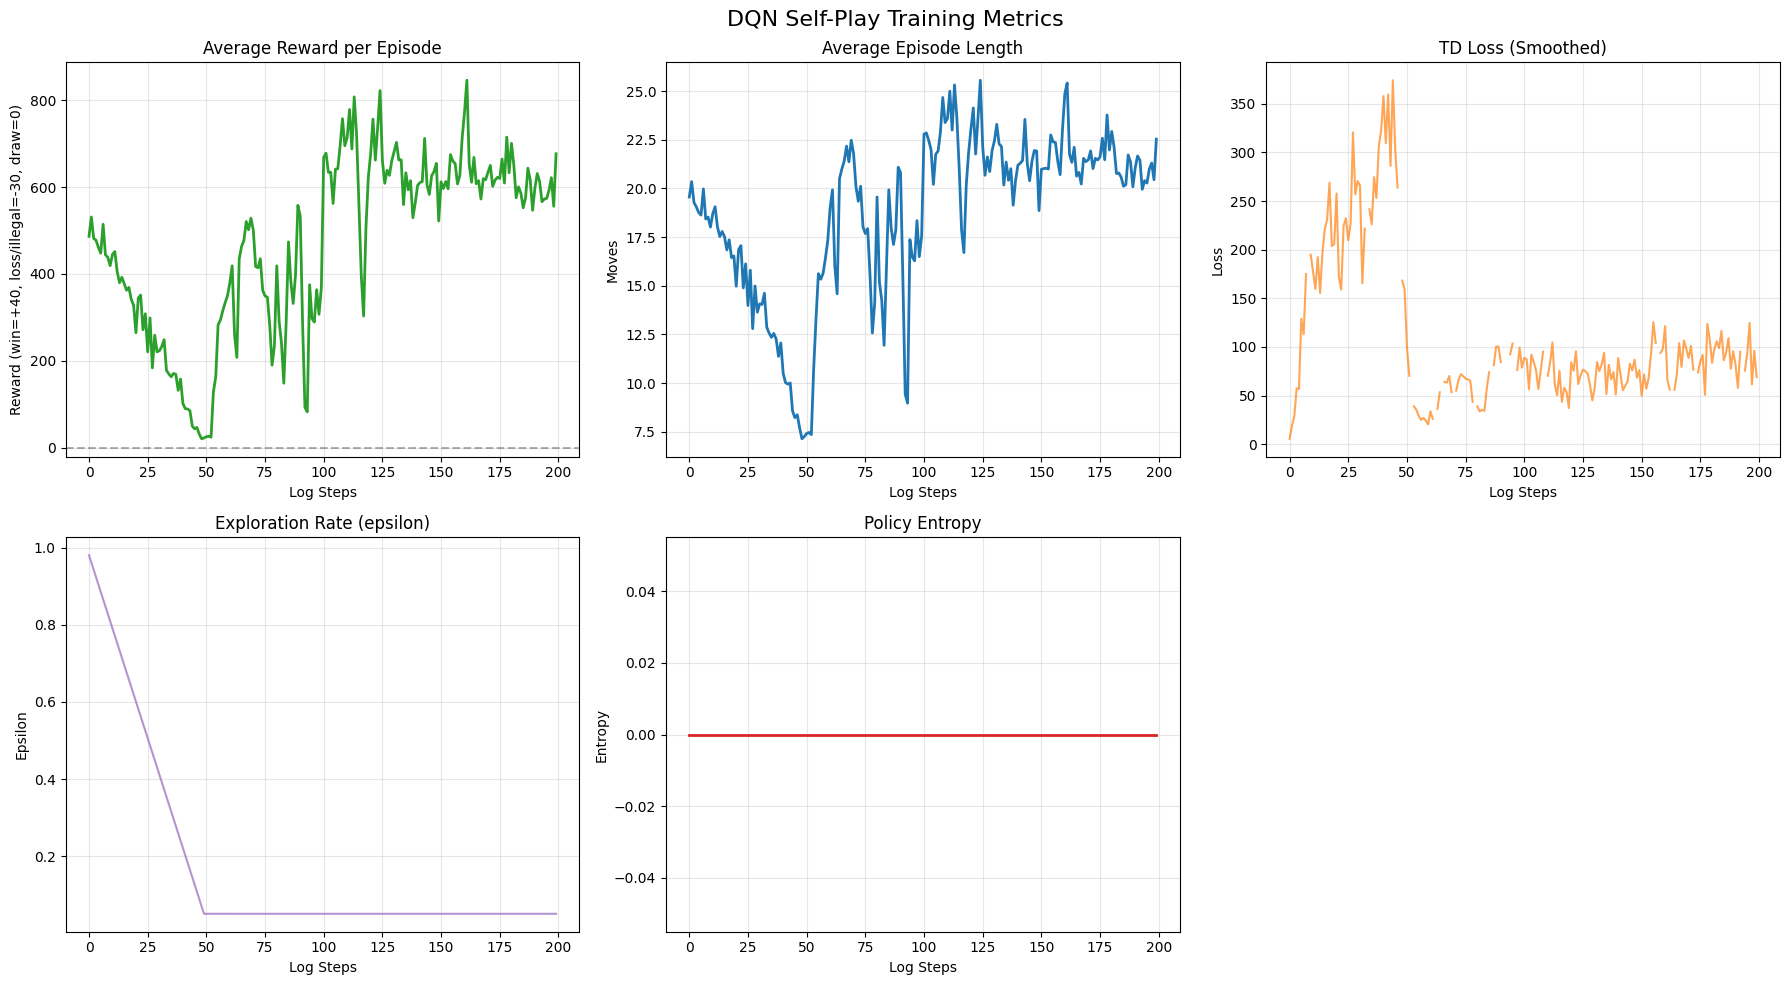

In [8]:

def plot_metrics(history):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('DQN Self-Play Training Metrics', fontsize=16)
    axes = axs.flatten()

    axes[0].plot(history['avg_reward'], color='#2ca02c', linewidth=2)
    axes[0].set_title("Average Reward per Episode")
    axes[0].set_ylabel("Reward (win=+40, loss/illegal=-30, draw=0)")
    axes[0].set_xlabel("Log Steps")
    axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history['avg_length'], color='#1f77b4', linewidth=2)
    axes[1].set_title("Average Episode Length")
    axes[1].set_ylabel("Moves")
    axes[1].set_xlabel("Log Steps")
    axes[1].grid(True, alpha=0.3)

    axes[2].plot(history['loss'], color='#ff7f0e', alpha=0.7)
    axes[2].set_title("TD Loss (Smoothed)")
    axes[2].set_ylabel("Loss")
    axes[2].set_xlabel("Log Steps")
    axes[2].grid(True, alpha=0.3)

    axes[3].plot(history['epsilon'], color='#9467bd', alpha=0.7)
    axes[3].set_title("Exploration Rate (epsilon)")
    axes[3].set_ylabel("Epsilon")
    axes[3].set_xlabel("Log Steps")
    axes[3].grid(True, alpha=0.3)

    axes[4].plot(history.get('entropy', []), color='#d62728', linewidth=2)
    axes[4].set_title("Policy Entropy")
    axes[4].set_ylabel("Entropy")
    axes[4].set_xlabel("Log Steps")
    axes[4].grid(True, alpha=0.3)

    axes[5].axis('off')

    plt.tight_layout()
    plt.show()

plot_metrics(history)


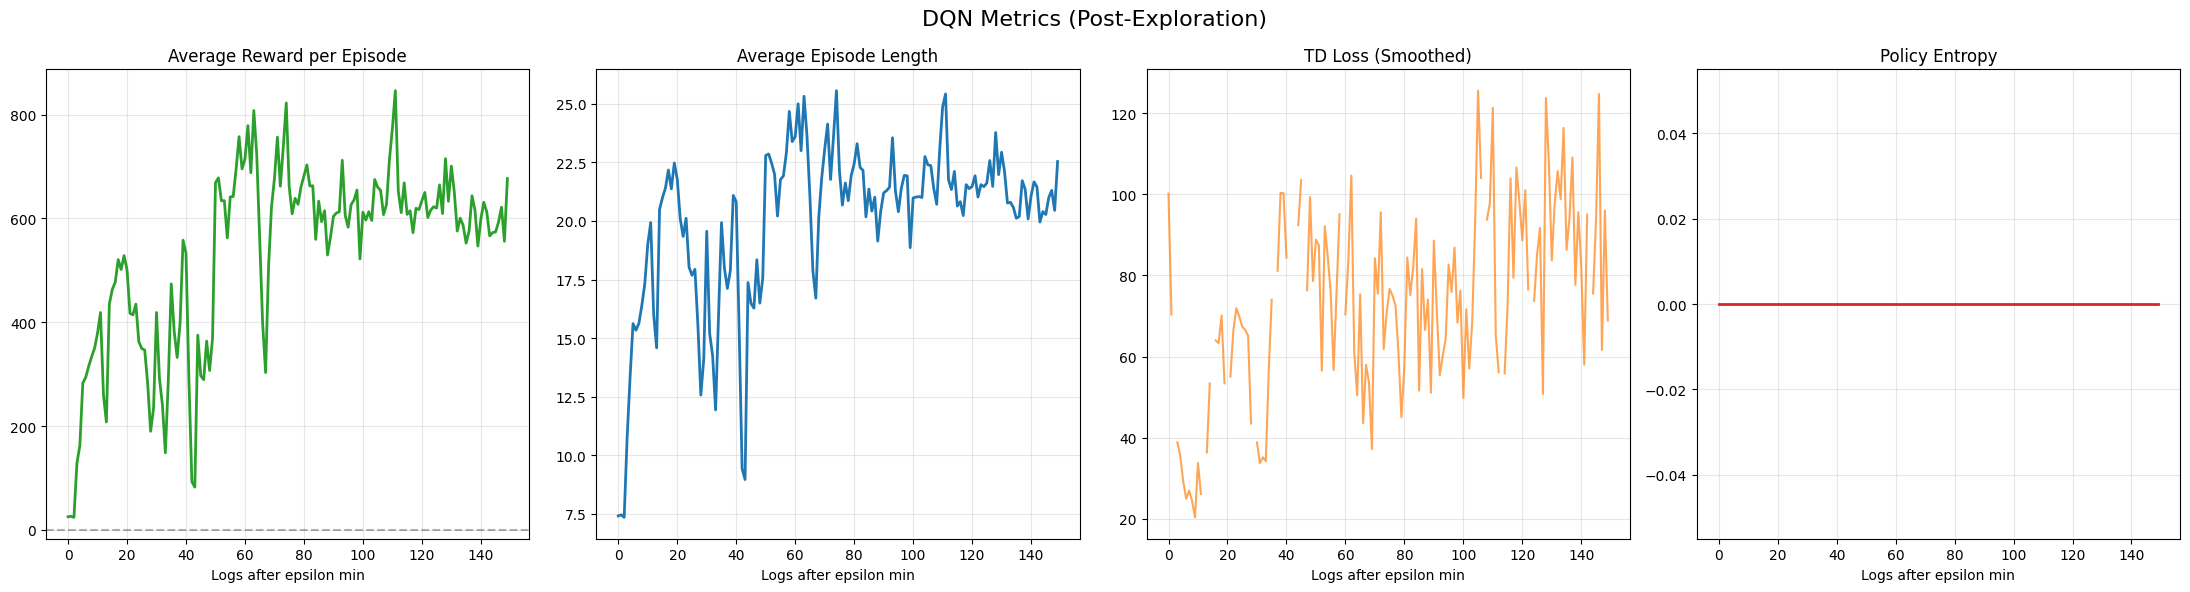

In [9]:

import numpy as np
import matplotlib.pyplot as plt

def plot_metrics_post_exploration(history):
    eps = np.array(history.get('epsilon', []), dtype=float)
    if eps.size == 0:
        print('No epsilon history found.')
        return

    final_eps = eps.min()
    zero_idx = np.where(eps <= final_eps + 1e-8)[0]
    start = int(zero_idx[0]) if zero_idx.size > 0 else 0

    sliced = {k: v[start:] for k, v in history.items() if isinstance(v, list)}
    if not sliced or len(sliced.get('avg_reward', [])) == 0:
        print('No data after exploration phase.')
        return

    fig, axs = plt.subplots(1, 4, figsize=(22, 6))
    fig.suptitle('DQN Metrics (Post-Exploration)', fontsize=16)

    axs[0].plot(sliced['avg_reward'], color='#2ca02c', linewidth=2)
    axs[0].set_title('Average Reward per Episode')
    axs[0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    axs[0].grid(True, alpha=0.3)

    axs[1].plot(sliced['avg_length'], color='#1f77b4', linewidth=2)
    axs[1].set_title('Average Episode Length')
    axs[1].grid(True, alpha=0.3)

    axs[2].plot(sliced['loss'], color='#ff7f0e', alpha=0.7)
    axs[2].set_title('TD Loss (Smoothed)')
    axs[2].grid(True, alpha=0.3)

    axs[3].plot(sliced.get('entropy', []), color='#d62728', linewidth=2)
    axs[3].set_title('Policy Entropy')
    axs[3].grid(True, alpha=0.3)

    for ax in axs:
        ax.set_xlabel('Logs after epsilon min')

    plt.tight_layout()
    plt.show()

plot_metrics_post_exploration(history)


In [10]:
def evaluate_agent(agent, n_games=100):
    env = ConnectFourEnv()
    agent.policy.eval()

    wins = 0
    losses = 0
    draws = 0

    for i in range(n_games):
        obs, info = env.reset()
        done = False

        # Randomly decide if Agent is Player 1 or Player 2
        agent_player_id = 0 if i % 2 == 0 else 1

        while not done:
            # Check whose turn it is
            current_turn = info.get('turn', 0)  # fallback to Player 1 if not provided

            legal_moves = info['legal_moves']

            if current_turn == agent_player_id:
                action = get_masked_action(agent, obs, legal_moves, deterministic=True)
            else:
                valid_cols = [c for c in range(env.cols) if legal_moves[c] == 1]
                action = random.choice(valid_cols)

            # Step
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            if done:
                last_info = info
                winner = last_info.get('winner', None)
                is_draw = bool(last_info.get('draw', False))
                illegal = bool(last_info.get('illegal_move', False))
                if winner is not None:
                    if current_turn == agent_player_id:
                        wins += 1
                    else:
                        losses += 1
                elif illegal:
                    if current_turn == agent_player_id:
                        losses += 1
                    else:
                        wins += 1
                else:
                    draws += 1

    print(f"Results over {n_games} games:")
    print(f"Wins: {wins} ({wins/n_games*100:.1f}%)")
    print(f"Losses: {losses} ({losses/n_games*100:.1f}%)")
    print(f"Draws: {draws} ({draws/n_games*100:.1f}%)")

    return wins, losses, draws

# Run Evaluation
print("Evaluating Agent vs Random...")
evaluate_agent(dqn_agent, n_games=100)


Evaluating Agent vs Random...
Results over 100 games:
Wins: 76 (76.0%)
Losses: 24 (24.0%)
Draws: 0 (0.0%)


(76, 24, 0)

Agent (Red/1) vs Random (Yellow/2)


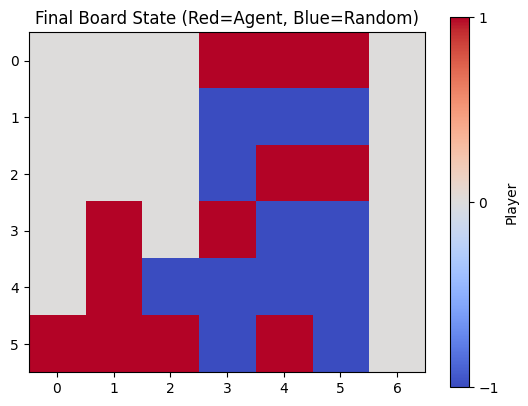

Winner: Agent


In [11]:
import matplotlib.pyplot as plt
import random

def play_demo_game(agent):
    env = ConnectFourEnv()
    obs, info = env.reset()
    done = False
    print('Agent (Red/1) vs Random (Yellow/2)')
    agent_player = 1
    last_actor = None
    while not done:
        legal_moves = info['legal_moves']
        actor = info['turn']
        last_actor = actor
        if actor == agent_player:
            action = get_masked_action(agent, obs, legal_moves, deterministic=True)
        else:
            valid_cols = [c for c in range(env.cols) if legal_moves[c] == 1]
            action = random.choice(valid_cols)
        obs, reward, term, trunc, info = env.step(action)
        done = term or trunc
    board = env.board.copy().astype(int)
    board_vis = board.copy()
    board_vis[board_vis == 2] = -1
    plt.imshow(board_vis, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Final Board State (Red=Agent, Blue=Random)')
    plt.colorbar(ticks=[-1, 0, 1], label='Player')
    plt.grid(False)
    plt.show()
    winner = info.get('winner', None)
    is_draw = bool(info.get('draw', False))
    illegal = bool(info.get('illegal_move', False))
    if winner is not None:
        winner_name = 'Agent' if last_actor == agent_player else 'Random'
        print(f'Winner: {winner_name}')
    elif illegal:
        loser_name = 'Agent' if last_actor == agent_player else 'Random'
        print(f'Illegal move by {loser_name}; other player wins.')
    else:
        print('Draw!')

play_demo_game(dqn_agent)

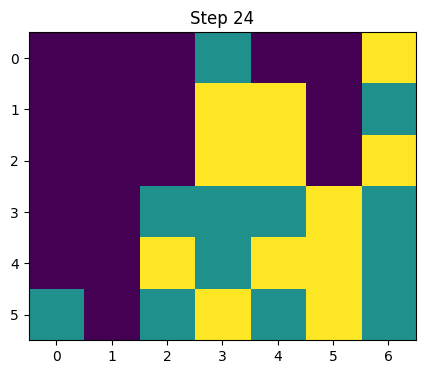

Game Over! Winner: Player 1


In [15]:

from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import numpy as np
import time

def masked_greedy_action(agent, obs, legal_moves):
    obs_tensor = torch.as_tensor(obs).float().unsqueeze(0).to(agent.device)
    with torch.no_grad():
        q_values = agent.policy.q_net(obs_tensor).squeeze(0).detach().cpu().numpy()
    legal_mask = np.array(legal_moves, dtype=bool)
    masked_q = q_values.copy()
    masked_q[~legal_mask] = -np.inf
    best = masked_q.max()
    best_actions = np.flatnonzero(masked_q == best)
    return int(np.random.choice(best_actions))

def watch_self_play(agent, sleep_time=0.5, max_steps=200):
    env = ConnectFourEnv()
    obs, info = env.reset()
    done = False

    fig, ax = plt.subplots(figsize=(5, 4))
    step_count = 0

    while not done and step_count < max_steps:
        legal_moves = info["legal_moves"]
        action = masked_greedy_action(agent, obs, legal_moves)

        obs, reward, term, trunc, info = env.step(action)
        done = term or trunc
        step_count += 1

        ax.clear()
        board = getattr(env, "board", None)
        if board is None:
            ax.text(0.5, 0.5, "env.board not found", ha="center", va="center")
        else:
            ax.imshow(board, aspect="auto")
        ax.set_title(f"Step {step_count}")
        if hasattr(env, "cols"):
            ax.set_xticks(range(env.cols))
        if hasattr(env, "rows"):
            ax.set_yticks(range(env.rows))

        clear_output(wait=True)
        display(fig)
        time.sleep(sleep_time)

    plt.close(fig)

    winner = info.get("winner", None)
    if winner is not None:
        print(f"Game Over! Winner: Player {winner}")
    elif info.get("illegal_move", False):
        print("Game Over! Illegal move termination.")
    else:
        print("Game Over! Draw.")

watch_self_play(dqn_agent, sleep_time=0.3)


In [13]:
def evaluate_self_play(agent, n_games=100):
    env = ConnectFourEnv()
    agent.policy.eval()

    p1_wins = 0
    p2_wins = 0
    draws = 0

    print(f"Running {n_games} self-play games (Stochastic Mode)...")

    for _ in range(n_games):
        obs, info = env.reset()
        done = False

        while not done:
            actor = info['turn']
            action = get_masked_action(agent, obs, info['legal_moves'], deterministic=False)
            obs, reward, term, trunc, info = env.step(action)
            done = term or trunc

            if done:
                winner = info.get('winner', None)
                is_draw = bool(info.get('draw', False))
                illegal = bool(info.get('illegal_move', False))
                if winner is not None:
                    if winner == 0:
                        p1_wins += 1
                    else:
                        p2_wins += 1
                elif illegal:
                    if actor == 0:
                        p2_wins += 1
                    else:
                        p1_wins += 1
                else:
                    draws += 1

    print("-" * 30)
    print(f"Self-Play Results ({n_games} Games):")
    print(f"Player 1 (Agent) Wins: {p1_wins} ({p1_wins/n_games*100:.1f}%)")
    print(f"Player 2 (Agent) Wins: {p2_wins} ({p2_wins/n_games*100:.1f}%)")
    print(f"Draws:                 {draws} ({draws/n_games*100:.1f}%)")
    print("-" * 30)

    # Interpretation
    if p1_wins > p2_wins + 20:
        print("Analysis: Strong First-Player Advantage detected.")
    elif abs(p1_wins - p2_wins) <= 20:
        print("Analysis: The agent is balanced (defends as well as it attacks).")
    else:
        print("Analysis: The agent actually plays better as Player 2 (Counter-Attacker).")

evaluate_self_play(dqn_agent, n_games=500)


Running 500 self-play games (Stochastic Mode)...
------------------------------
Self-Play Results (500 Games):
Player 1 (Agent) Wins: 259 (51.8%)
Player 2 (Agent) Wins: 239 (47.8%)
Draws:                 2 (0.4%)
------------------------------
Analysis: The agent is balanced (defends as well as it attacks).


In [14]:
class RandomAgent:
    def get_action(self, obs, info):
        legal_moves = info['legal_moves']
        valid_cols = [c for c in range(7) if legal_moves[c] == 1]
        return random.choice(valid_cols)

class GreedyAgent:
    """
    A baseline that:
    1. Prefers the center column if it is legal.
    2. Otherwise plays random.
    """
    def __init__(self):
        self.env = ConnectFourEnv() # Internal env for simulation

    def get_action(self, obs, info):
        legal_moves = info['legal_moves']
        valid_cols = [c for c in range(7) if legal_moves[c] == 1]

        if 3 in valid_cols:
            return 3

        # 3. Random
        return random.choice(valid_cols)

def run_evaluation_metrics(agent, opponent_type="random", n_games=100):
    env = ConnectFourEnv()
    agent.policy.eval()

    rewards, lengths = [], []
    outcomes = {"win": 0, "loss": 0, "draw": 0}

    opponent = RandomAgent()  # or your other baseline
    print(f"Evaluating: DQN Agent vs {opponent_type.capitalize()} ({n_games} games)...")

    agent_player = 0  # agent is Red/Player 1

    for _ in range(n_games):
        obs, info = env.reset()
        done = False
        steps = 0
        episode_reward = 0
        last_actor = None

        while not done:
            steps += 1
            legal_moves = info["legal_moves"]
            actor = info["turn"]
            last_actor = actor

            if actor == agent_player:
                action = get_masked_action(agent, obs, legal_moves, deterministic=True)
            else:
                action = opponent.get_action(obs, info)

            obs, reward, term, trunc, info = env.step(action)
            done = term or trunc

        # Outcome relative to the agent (player 1)
        # Use env info flags (winner/draw/illegal_move); env returns +40/-30/0 with shaping, so the final reward magnitude is not fixed.
        last_info = info
        winner = last_info.get("winner", None)
        is_draw = bool(last_info.get("draw", False))
        illegal_move = bool(last_info.get("illegal_move", False))

        if winner is not None:
            if last_actor == agent_player:
                episode_reward = 1
                outcomes["win"] += 1
            else:
                episode_reward = -1
                outcomes["loss"] += 1
        elif illegal_move:
            if last_actor == agent_player:
                episode_reward = -1
                outcomes["loss"] += 1
            else:
                episode_reward = 1
                outcomes["win"] += 1
        else:
            episode_reward = 0
            outcomes["draw"] += 1

        rewards.append(episode_reward)
        lengths.append(steps)

    avg_reward = np.mean(rewards); std_reward = np.std(rewards)
    avg_len = np.mean(lengths); win_rate = outcomes["win"] / n_games * 100
    results = {
        "avg_reward": avg_reward,
        "std_reward": std_reward,
        "avg_length": avg_len,
        "win_rate": win_rate,
        "outcomes": outcomes,
    }
    print(f"  > Average Reward: {avg_reward:.3f} +/- {std_reward:.3f}")
    print(f"  > Average Length: {avg_len:.1f} moves")
    print(f"  > Win Rate:       {win_rate:.1f}%")
    return results

# Run the standard evaluation
metrics = run_evaluation_metrics(dqn_agent, "random", n_games=200)


Evaluating: DQN Agent vs Random (200 games)...
  > Average Reward: 0.550 +/- 0.835
  > Average Length: 15.0 moves
  > Win Rate:       77.5%
